# Data Analysis

1. Data acquired from https://www.kaggle.com/datasets/koelin/retail-purchase-history?resource=download
0. 

## Dependencies

In [1]:
import shutil
import sys
from collections.abc import Callable
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:

# --- AUTO-SYNC FROM GITHUB ---
# DO NOT EDIT

COLAB_ACTIVE = 'google.colab' in sys.modules

if COLAB_ACTIVE:
    REPO_URL = 'https://github.com/Ri-Dearg/ca2-market-retail.git'
    REPO_DIR = '/content/repo'

    if not Path(REPO_DIR).exists():
        !git clone $REPO_URL $REPO_DIR
    elif not Path(Path(REPO_DIR) / '.git').exists():
        shutil.rmtree(REPO_DIR)
        !git clone $REPO_URL $REPO_DIR
    else:
        %cd $REPO_DIR
        !git pull origin main

    %cd /content/repo
else:
    print('Running locally, not in Colab')


Running locally, not in Colab


## Utilities

In [3]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: Callable,
    data: pd.DataFrame,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
    *,
    y_col: bool = False,
    y_val: str = '',
    **kwargs: dict[str, Any],
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (Callable): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).
        y_col(None, optional): x axis if doing a correlation plot.
        y_val(str, optional): Value to plot on y axis.
        **kwargs(dict, optional): keyword for the seaborn function

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()
    # Cheks to see if it is a correlation plot.
    if y_col is True:
        for i, item in enumerate(data_cols[1:]):
            seaborn_func(data=data, x=item, y=y_val, ax=axes[i], **kwargs)
    # Runs single predictor plot if not.
    else:
        for i, item in enumerate(data_cols):
            seaborn_func(data=data, x=item, ax=axes[i], **kwargs)

    # Hide any unused subplots.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


In [4]:
# Load in excel file as data
retail_data = pd.read_excel('online_retail.xlsx', sheet_name=None)
combined_retail = pd.concat(
    retail_data.values(),
    ignore_index=True)
combined_retail

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
combined_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
# Extract just Irish data as data frame
eire_data = combined_retail[combined_retail["Country"] == "EIRE"].copy()
eire_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE
...,...,...,...,...,...,...,...,...
1064612,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE
1064613,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
1064614,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
1064615,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE


In [7]:
# Create a Total Cost Column
eire_data['Total Cost'] = eire_data['Quantity'] * eire_data['Price']

In [8]:
# Describe data.
# Note that not all columns have an associated customer ID
eire_data.info()
# Quantity goes into negative, probably represents returns or cancellations
eire_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17866 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17866 non-null  object        
 1   StockCode    17866 non-null  object        
 2   Description  17866 non-null  object        
 3   Quantity     17866 non-null  int64         
 4   InvoiceDate  17866 non-null  datetime64[ns]
 5   Price        17866 non-null  float64       
 6   Customer ID  16195 non-null  float64       
 7   Country      17866 non-null  object        
 8   Total Cost   17866 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.4+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17866.000000,17866,17866.000000,16195.000000,17866.000000
mean,18.545897,2010-12-23 21:21:35.823351552,7.013626,14693.529793,34.452007
min,-400.000000,2009-12-01 11:41:00,0.000000,12745.000000,-2736.160000
25%,4.000000,2010-06-29 09:32:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-15 13:55:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-28 14:27:00,4.950000,14911.000000,29.900000
max,1440.000000,2011-12-08 15:54:00,2736.160000,16047.000000,2736.160000
std,47.224288,NaN,64.900981,347.429356,106.460374


In [9]:
eire_data.to_csv('eire_retail.csv')

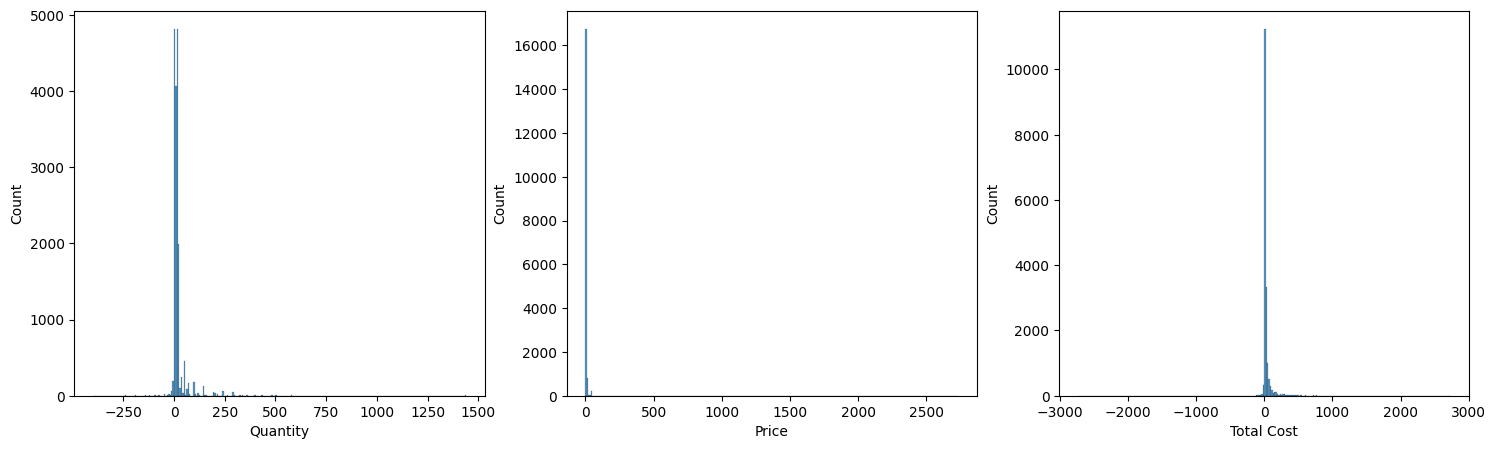

In [10]:
# The outliers make the majority of data hard to visualise
multi_row_plot(
    sns.histplot,
    eire_data[['Quantity', 'Price', 'Total Cost']],
    grid=(1, 3),
    size=(18, 5),
)

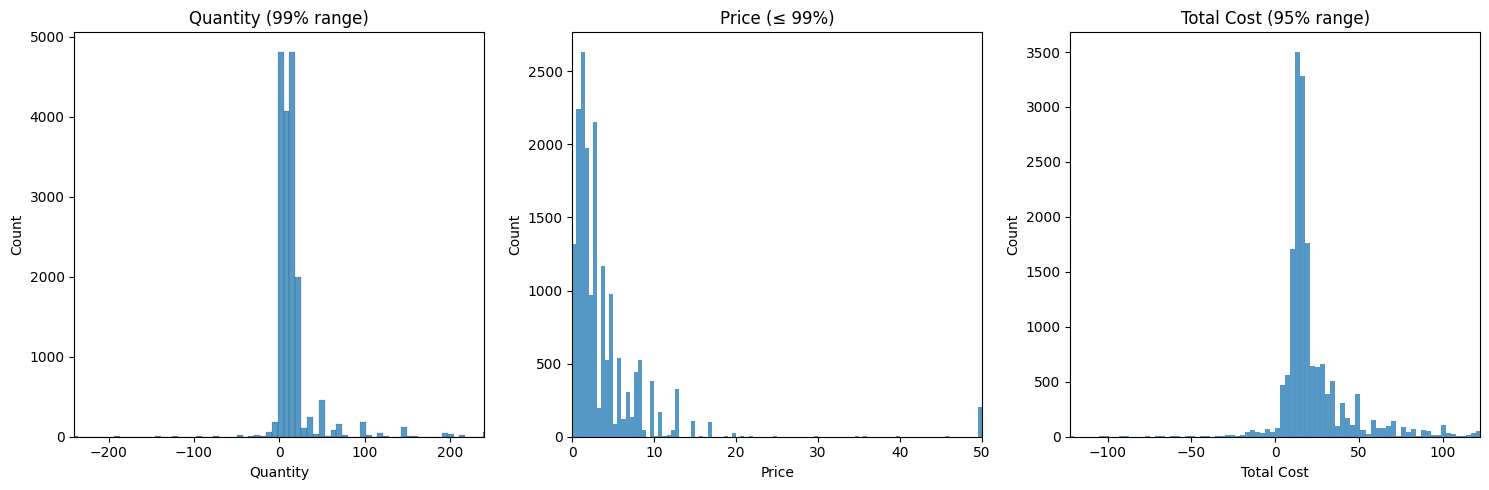

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Quantity (99% range) ---
sns.histplot(eire_data['Quantity'], ax=axes[0])
q99 = eire_data['Quantity'].abs().quantile(0.99)
axes[0].set_xlim(-q99, q99)
axes[0].set_title('Quantity (99% range)')

# --- Price (≤ 99%) ---
sns.histplot(eire_data['Price'], binwidth=0.5, ax=axes[1])
axes[1].set_xlim(0, eire_data['Price'].quantile(0.99))
axes[1].set_title('Price (≤ 99%)')

# --- Total Cost (95% range) ---
sns.histplot(eire_data['Total Cost'], binwidth=3, ax=axes[2])
tc95 = eire_data['Total Cost'].abs().quantile(0.95)
axes[2].set_xlim(-tc95, tc95)
axes[2].set_title('Total Cost (95% range)')

plt.tight_layout()
plt.show()


# Clean Data

Remove returns / cancelled orders / manual entries / non-products

In [12]:
non_product_codes = ['M', 'C2', 'ADJUST', 'POST', 'D', 'BANK CHARGES']

clean_data_v1 = eire_data[~eire_data['StockCode'].isin(non_product_codes)].copy()
clean_data_v1


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Cost
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE,9.0
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE,15.0
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE,31.6
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE,12.6
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE,13.5
...,...,...,...,...,...,...,...,...,...
1064612,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE,17.0
1064613,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5
1064614,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5
1064615,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5


In [13]:
clean_data_v1.info()
clean_data_v1.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17583 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17583 non-null  object        
 1   StockCode    17583 non-null  object        
 2   Description  17583 non-null  object        
 3   Quantity     17583 non-null  int64         
 4   InvoiceDate  17583 non-null  datetime64[ns]
 5   Price        17583 non-null  float64       
 6   Customer ID  15946 non-null  float64       
 7   Country      17583 non-null  object        
 8   Total Cost   17583 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.3+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17583.000000,17583,17583.000000,15946.000000,17583.000000
mean,18.832736,2010-12-24 07:17:29.868622848,3.485544,14692.772858,34.609133
min,-400.000000,2009-12-01 11:41:00,0.000000,14016.000000,-1224.000000
25%,4.000000,2010-06-30 09:37:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-15 14:26:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-28 15:16:00,4.650000,14911.000000,29.700000
max,1440.000000,2011-12-08 15:54:00,165.000000,14911.000000,2365.200000
std,47.548160,NaN,3.958058,347.370486,84.984633


In [14]:
key_cols = ['Invoice', 'Customer ID',  'InvoiceDate', 'StockCode', 'Quantity']

dupes = clean_data_v1[clean_data_v1.duplicated(subset=key_cols, keep=False)]
dupes.info()
dupes.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 180796 to 971559
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      392 non-null    object        
 1   StockCode    392 non-null    object        
 2   Description  392 non-null    object        
 3   Quantity     392 non-null    int64         
 4   InvoiceDate  392 non-null    datetime64[ns]
 5   Price        392 non-null    float64       
 6   Customer ID  356 non-null    float64       
 7   Country      392 non-null    object        
 8   Total Cost   392 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.6+ KB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,392.000000,392,392.000000,356.000000,392.000000
mean,19.933673,2010-12-09 15:01:30.000000256,4.053929,14860.101124,27.631480
min,-24.000000,2010-04-30 11:48:00,0.120000,14156.000000,-61.200000
25%,4.000000,2010-12-03 14:04:00,1.250000,14911.000000,15.000000
50%,10.000000,2010-12-03 14:04:00,2.100000,14911.000000,19.900000
75%,12.000000,2010-12-06 13:06:00,5.950000,14911.000000,31.600000
max,1440.000000,2011-11-07 13:06:00,21.950000,14911.000000,230.400000
std,102.788889,NaN,4.219305,189.575600,29.284998


In [15]:
# Drop duplicate
clean_data_v2 = clean_data_v1.drop_duplicates(subset=key_cols, keep="first").copy()
clean_data_v2.info()
clean_data_v2.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 17387 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17387 non-null  object        
 1   StockCode    17387 non-null  object        
 2   Description  17387 non-null  object        
 3   Quantity     17387 non-null  int64         
 4   InvoiceDate  17387 non-null  datetime64[ns]
 5   Price        17387 non-null  float64       
 6   Customer ID  15768 non-null  float64       
 7   Country      17387 non-null  object        
 8   Total Cost   17387 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.3+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17387.000000,17387,17387.000000,15768.000000,17387.000000
mean,18.820326,2010-12-24 11:15:45.568528128,3.479137,14690.883942,34.687790
min,-400.000000,2009-12-01 11:41:00,0.000000,14016.000000,-1224.000000
25%,4.000000,2010-06-25 10:22:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-12 10:28:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-29 13:39:00,4.250000,14911.000000,29.500000
max,1440.000000,2011-12-08 15:54:00,165.000000,14911.000000,2365.200000
std,46.556360,NaN,3.954614,348.287608,85.402636


In [16]:
clean_data_v2.to_csv('clean_data_v2.csv')

In [17]:
product_revenue = clean_data_v2.groupby('StockCode', as_index=False).agg({
        'InvoiceDate': 'first',
        'Description': 'first',
        'Quantity': 'sum',
        'Price': 'mean',
        'Total Cost': 'sum'
    })
product_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StockCode    2838 non-null   object        
 1   InvoiceDate  2838 non-null   datetime64[ns]
 2   Description  2838 non-null   object        
 3   Quantity     2838 non-null   int64         
 4   Price        2838 non-null   float64       
 5   Total Cost   2838 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 133.2+ KB


In [18]:
product_revenue.to_csv('stock_revenue.csv')

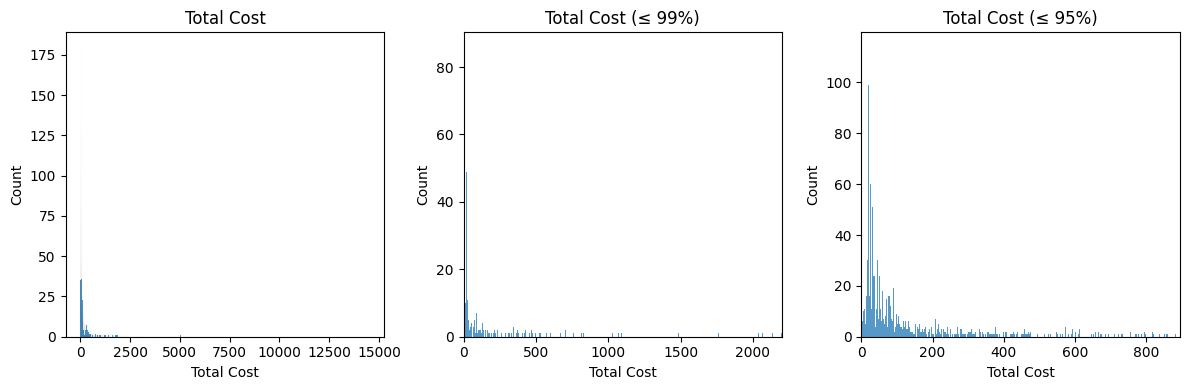

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(
    product_revenue["Total Cost"],
    binwidth=3,
    ax=axes[0]
)
axes[0].set_title("Total Cost")

sns.histplot(
    product_revenue["Total Cost"],
    binwidth=0.5,
    ax=axes[1]
)
axes[1].set_xlim(0, product_revenue["Total Cost"].quantile(0.99))
axes[1].set_title("Total Cost (≤ 99%)")

sns.histplot(
    product_revenue["Total Cost"],
    binwidth=1,
    ax=axes[2]
)
axes[2].set_xlim(0, product_revenue["Total Cost"].quantile(0.95))
axes[2].set_title("Total Cost (≤ 95%)")

plt.tight_layout()
plt.show()

In [20]:
top_20_products = (
    product_revenue
    .sort_values("Total Cost", ascending=False)
    .head(20)
)

top_20_products

,StockCode,InvoiceDate,Description,Quantity,Price,Total Cost
1102,22423,2010-03-22 11:21:00,REGENCY CAKESTAND 3 TIER,1275,12.094481,14537.55
151,20914,2009-12-08 13:49:00,SET/5 RED SPOTTY LID GLASS BOWLS,2922,2.846774,7698.70
680,21843,2009-12-07 13:49:00,RETRO SPOT CAKE STAND,565,10.932143,6162.75
2706,85123A,2009-12-07 09:25:00,WHITE HANGING HEART T-LIGHT HOLDER,2071,2.845455,5560.65
274,21166,2010-02-07 14:27:00,COOK WITH WINE METAL SIGN,3091,1.934792,5528.08
282,21181,2009-12-01 11:41:00,PLEASE ONE PERSON METAL SIGN,2670,2.037500,5031.00
472,21523,2009-12-01 11:41:00,FANCY FONT HOME SWEET HOME DOORMAT,692,7.219149,4574.40
55,20685,2009-12-21 13:04:00,RED SPOTTY COIR DOORMAT,696,7.071111,4490.42
275,21169,2010-02-07 14:27:00,YOU'RE CONFUSING ME METAL SIGN,2855,1.560769,4179.83
473,21524,2010-01-07 12:34:00,SPOTTY HOME SWEET HOME DOORMAT,599,7.292889,3907.13


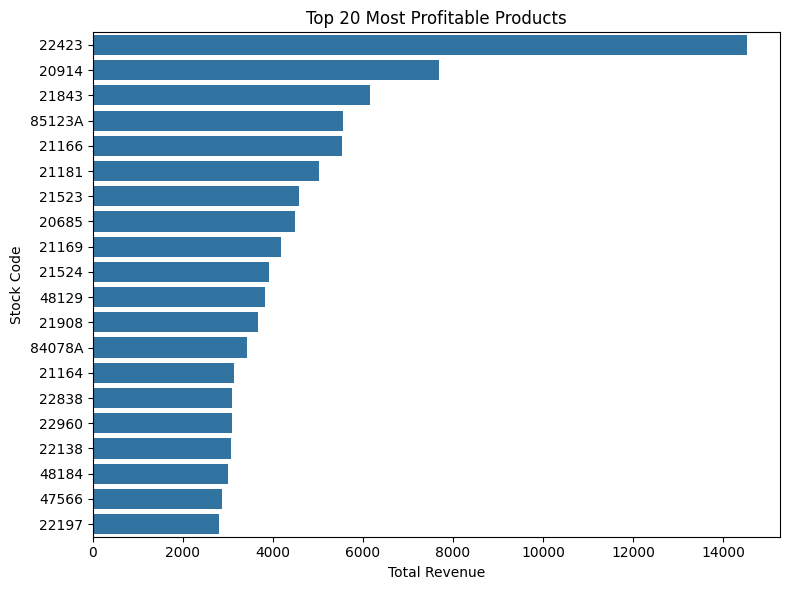

In [21]:
plt.figure(figsize=(8, 6))

sns.barplot(
    data=top_20_products,
    x="Total Cost",
    y="StockCode",
    orient="h"
)

plt.title("Top 20 Most Profitable Products")
plt.xlabel("Total Revenue")
plt.ylabel("Stock Code")
plt.tight_layout()
plt.show()